In [1]:
from collections import defaultdict
import gzip, pickle

import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from breit_wigner import BreitWigner

import tqdm.auto as tqdm
import numpy as np
import pandas as pd
import awkward as ak
from uproot_methods import TLorentzVectorArray

%matplotlib inline
import matplotlib.pyplot as plt

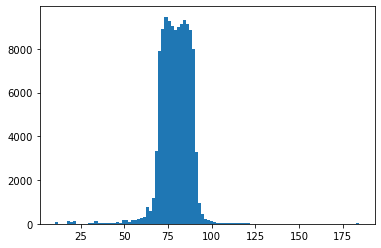

In [2]:
events = ak.load('events.awkd')
genp = events.particles
genp['p4'] = TLorentzVectorArray.from_cartesian(
    genp.px,
    genp.py,
    genp.pz,
    genp.e,
)

plt.hist(genp[genp.isFinal].p4.sum().mass, bins=100);

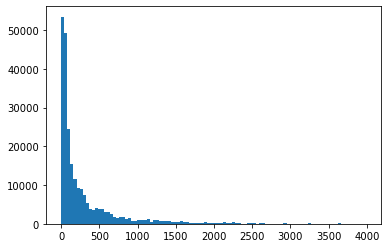

In [3]:
plt.hist(genp[genp.isFinal].p4.energy.flatten(), bins=100);

In [4]:
train_frac = 0.7
train_mask = np.random.random(events.size) < train_frac
n_train = sum(train_mask)

def stack_inputs(events, mask):
    p4 = events.particles.p4[events.particles.isFinal]
    assert np.all(p4.counts == 2)
    stack = np.array([
        p4[mask, 0].pt,
        p4[mask, 0].eta,
        p4[mask, 0].phi,
        p4[mask, 0].mass,
        p4[mask, 1].pt,
        p4[mask, 1].eta,
        p4[mask, 1].phi,
        p4[mask, 1].mass,
    ], dtype='f4').T
    return stack

x_train = stack_inputs(events, train_mask)
x_test = stack_inputs(events, ~train_mask)

def stack_outputs(events, mask):
    stack = np.array([
        events[mask].wMass,
        events[mask].wWidth,
    ], dtype='f4').T
    return stack

y_train = stack_outputs(events, train_mask)
y_test = stack_outputs(events, ~train_mask)

In [5]:
class WMassVAE(tfk.Model):
    def __init__(self, latent_dist_fn, n_params, input_shape):
        super(WMassVAE, self).__init__()

        self.latent_dist_fn = latent_dist_fn
        self.n_params = n_params
        self._input_shape = input_shape

        self.encoder = tfk.Sequential([
            tfk.layers.Input(input_shape),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(n_params),
        ])
        
        self.latent_prior = self.latent_dist_fn()
        
        self.decoder = tfk.Sequential([
            tfk.layers.Input(self.latent_prior.event_shape),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(64, activation='relu'),
            tfk.layers.Dense(input_shape * 2),
        ])
    
    def encode(self, inputs):
        '''Encode
        '''
        param = self.encoder(inputs)
        dist = self.latent_dist_fn(param)
        return dist
    
    def decode(self, inputs):
        '''Decode
        '''
        param = self.decoder(inputs)
        dist = tfd.MultivariateNormalDiag(
            loc=param[..., :self._input_shape],
            scale_diag=tf.math.softplus(param[..., self._input_shape:]),
        )
        return dist
    
    def call(self, inputs):
        latent = self.encode(inputs)
        sample = latent.sample()
        out = self.decode(sample)
        return out

In [6]:
def make_dist(inputs=None, *args, **kwargs):
    if inputs is None:
        bw_mass, bw_width = tf.constant(81.*81.), tf.constant(81.*2.)
    else:
        bw_mass, bw_width = inputs[..., 0], inputs[..., 1]
        bw_width = tf.math.softplus(bw_width)

    batch_shape = bw_mass.shape
    return tfd.Blockwise([
        tfd.Cauchy(bw_mass, bw_width),
        tfd.Independent(
            tfd.Uniform(
                low=tf.zeros(batch_shape + (4,)),
                high=tf.ones(batch_shape + (4,))
            ),
            reinterpreted_batch_ndims=1,
        ),
    ])

model = WMassVAE(make_dist, 2, 8)
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                384       
________________________________

In [7]:
optimizer = tfk.optimizers.Adam()

train_loss = tfk.metrics.Mean(name='train_loss')
test_loss = tfk.metrics.Mean(name='test_loss')

BATCH_SIZE = 100

train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .shuffle(10000)
            .batch(BATCH_SIZE, drop_remainder=True)
           )

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .batch(BATCH_SIZE, drop_remainder=True)
          )

In [8]:
@tf.function
def sampling_kl(dist_a, dist_b):
    samples = dist_a.sample(10)
    logp_a = tf.reduce_mean(dist_a.log_prob(samples), axis=0)
    logp_b = tf.reduce_mean(dist_b.log_prob(samples), axis=0)
    return logp_a - logp_b

In [9]:
@tf.function
def loss_fn(inputs, labels):
    latent = model.encode(inputs)
    kl = sampling_kl(latent, model.latent_prior)
    sample = latent.sample()
    output = model.decode(sample)
    nlogp = - output.log_prob(inputs)

    loss = nlogp + kl
    return tf.reduce_mean(loss[tf.math.is_finite(loss)])

In [10]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(inputs, labels)

    trainable = model.trainable_variables
    gradients = tape.gradient(loss, trainable)
    optimizer.apply_gradients(zip(gradients, trainable))

    train_loss(loss)

In [11]:
@tf.function
def test_step(inputs, labels):
    loss = loss_fn(inputs, labels)
    test_loss(loss)

In [12]:
EPOCHS = 5

history = defaultdict(list)

for epoch in tqdm.trange(EPOCHS, unit='epoch'):
    optimizer.lr = 1e-4
    for inputs, labels in train_ds:
        train_step(inputs, labels)

    for test_inputs, test_labels in test_ds:
        test_step(test_inputs, test_labels)

    history['train_loss'].append(float(train_loss.result()))
    history['test_loss'].append(float(test_loss.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    test_loss.reset_states()


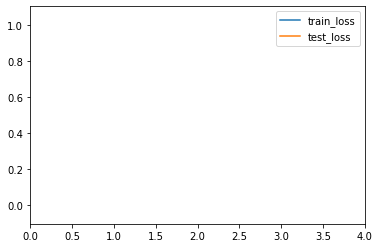

In [13]:
pd.DataFrame(history)[:].plot()

/Users/ncsmith/miniconda3/envs/tfp/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6735: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/ncsmith/miniconda3/envs/tfp/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6736: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

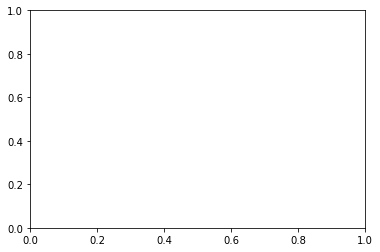

In [14]:
cut = y_test[:, 0] == 70
latent = model.encode(x_test[cut])

m = np.sqrt(latent.distributions[0].loc.numpy())
w = latent.distributions[0].scale.numpy() / m

plt.hist(m, bins=100);